In [1]:
import os
os.chdir("../")
%pwd

'd:\\Final-Year-Project\\Credit-Card-Fraud-Detection-Using-GNN'

In [2]:
from dataclasses import dataclass
from pathlib import Path
import os
from torch_geometric.data import HeteroData
from Credit_Card_Fraud_Detection import logger

In [3]:
from Credit_Card_Fraud_Detection.constants import *
from Credit_Card_Fraud_Detection.utils.common import read_yaml, create_directories

In [4]:
@dataclass(frozen=True)
class ModelTestingConfig:
    model_path: Path
    test_graph_data_path: Path
    root_dir: Path
    hidden_channels: int
    learning_rate: float
    epochs: int

In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath=CONFIG_FILE_PATH,
        params_filepath=PARAMS_FILE_PATH,
        schema_filepath=SCHEMA_FILE_PATH,
    ):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_testing_config(self) -> ModelTestingConfig:
        config = self.config.model_testing
        params = self.params.GCN

        create_directories([config.root_dir])

        model_testing_config = ModelTestingConfig(
            root_dir=config.root_dir,
            model_path=config.model_path,
            test_graph_data_path=config.test_graph_data_path,
            hidden_channels=params.hidden_channels,
            learning_rate=params.learning_rate,
            epochs=params.epochs,
        )

        return model_testing_config


In [6]:
import torch
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging
import os
from dataclasses import dataclass
from pathlib import Path

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import logging
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


class GNN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim):
        super(GNN, self).__init__()
        self.conv1 = HeteroConv({edge_type: SAGEConv((-1, -1), hidden_dim) for edge_type in metadata[1]}, aggr='mean')
        self.conv2 = HeteroConv({edge_type: SAGEConv((-1, -1), hidden_dim) for edge_type in metadata[1]}, aggr='mean')
        self.conv3 = HeteroConv({edge_type: SAGEConv((-1, -1), hidden_dim) for edge_type in metadata[1]}, aggr='mean')
        self.lin = torch.nn.Linear(hidden_dim, 1)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = {key: self.dropout(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = {key: self.dropout(x) for key, x in x_dict.items()}
        x_dict = self.conv3(x_dict, edge_index_dict)
        return self.lin(x_dict["transaction"]).squeeze(-1)
    
    
class GNNTester:
    def __init__(self, config):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.data = torch.load(self.config.test_graph_data_path).to(self.device)
        self.model = self._load_model().to(self.device)

    def _load_model(self):
        metadata = (list(self.data.x_dict.keys()), list(self.data.edge_index_dict.keys()))
        model = GNN(metadata, hidden_dim=self.config.hidden_channels)
        model.load_state_dict(torch.load(self.config.model_path, map_location=self.device))
        model.eval()
        return model

    def test_model(self):
        logger.info("Testing the model...")
        with torch.no_grad():
            logits = self.model(self.data.x_dict, self.data.edge_index_dict)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            labels = self.data["transaction"].y.cpu().numpy()

        accuracy = accuracy_score(labels, preds)
        precision = precision_score(labels, preds)
        recall = recall_score(labels, preds)
        f1 = f1_score(labels, preds)
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        
        logger.info(f"Accuracy: {accuracy:.4f}")
        logger.info(f"Precision: {precision:.4f}")
        logger.info(f"Recall: {recall:.4f}")
        logger.info(f"F1 Score: {f1:.4f}")
        logger.info(f"ROC AUC: {roc_auc:.4f}")

        # Plot ROC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Confusion Matrix
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        return accuracy, precision, recall, f1, roc_auc


[2025-03-24 18:51:37,375: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-24 18:51:37,377: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-24 18:51:37,380: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-03-24 18:51:37,381: INFO: common: created directory at: artifacts]
Available attributes in config_manager: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'config', 'get_model_testing_config', 'params', 'schema']
[2025-03-24 18:51:37,381: INFO: common: created directory at: artifacts/Testing]
Fetched model_testing_config: ModelTestingConfig(model_path='artifacts/model_trainer/fraud_detection_gcn.pth', test_graph_data_path='artifacts/T

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26900\4175703305.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(self.config.test_graph_data_path).t

[2025-03-24 18:51:38,034: INFO: 4175703305: Accuracy: 0.9885]
[2025-03-24 18:51:38,039: INFO: 4175703305: Precision: 0.1920]
[2025-03-24 18:51:38,039: INFO: 4175703305: Recall: 0.6922]
[2025-03-24 18:51:38,039: INFO: 4175703305: F1 Score: 0.3006]
[2025-03-24 18:51:38,040: INFO: 4175703305: ROC AUC: 0.9412]


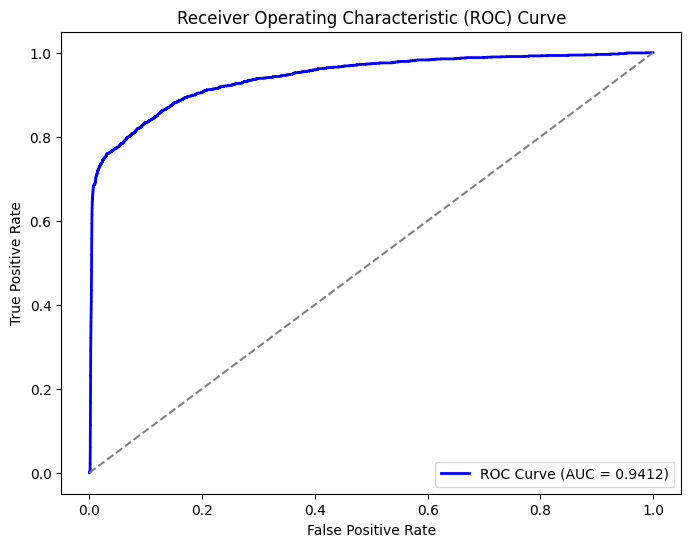

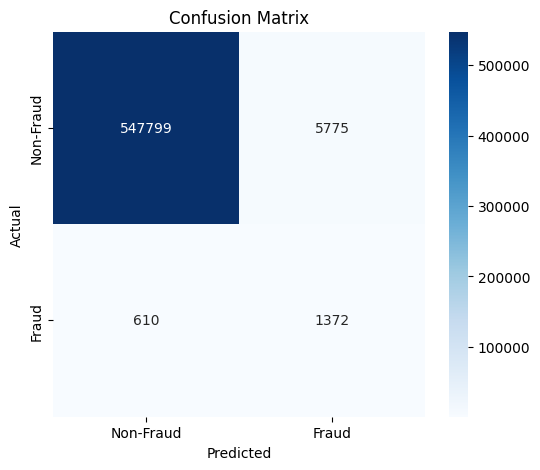

In [9]:
try:
    # Initialize ConfigurationManager
    config_manager = ConfigurationManager()
    
    # Debugging: Print available attributes of config_manager
    print("Available attributes in config_manager:", dir(config_manager))

    # Fetch model testing config
    model_testing_config = config_manager.get_model_testing_config()

    # Debugging: Print fetched model_testing_config details
    print("Fetched model_testing_config:", model_testing_config)

    # Initialize and run model tester
    model_tester = GNNTester(config=model_testing_config)
    model_tester.test_model()

except Exception as e:
    logger.error(f"An error occurred during model testing: {e}", exc_info=True)
